In [15]:
import torch
import os
import sys
import matplotlib.pyplot as plt
import argparse
import numpy as np
from tqdm.auto import tqdm
import torch.nn.functional as F

sys.path.append("../../")
from src.filepath import ABSOLUTE_PATH
from src.model.UNet2d import Unet2D
from src.model.fno import FNO2D
from src.utils.utils import plot_compare_2d, relative_error, get_parameter_net
from src.train.reaction_diffusion import cond_emb, renormalize
from src.train.reaction_diffusion import normalize_to_neg_one_to_one as normalize

In [10]:
model_type = "Unet"

In [11]:
channel, out_dim, dim = 2, 1, 24
if model_type == "Unet":

    model1 = Unet2D(dim=dim, cond_emb=cond_emb(), out_dim=out_dim, dim_mults=(1, 2), channels=channel).to("cuda")

    model2 = Unet2D(dim=dim, cond_emb=cond_emb(), out_dim=out_dim, dim_mults=(1, 2), channels=channel).to("cuda")

    model1.load_state_dict(torch.load("../../results/reaction_diffusion/surrogateUnetu10000/model.pt")["model"])

    model2.load_state_dict(torch.load("../../results/reaction_diffusion/surrogateUnetv10000/model.pt")["model"])
elif model_type == "FNO":
    model1 = FNO2D(
        in_channels=channel,
        out_channels=out_dim,
        nr_fno_layers=4,
        fno_layer_size=24,
        fno_modes=[6, 12],
        time_input=False,
        cond_emb=cond_emb(),
    ).to("cuda")
    model2 = FNO2D(
        in_channels=channel,
        out_channels=out_dim,
        nr_fno_layers=4,
        fno_layer_size=24,
        fno_modes=[6, 12],
        time_input=False,
        cond_emb=cond_emb(),
    ).to("cuda")
    model1.load_state_dict(torch.load("../../results/reaction_diffusion/surrogateFNOu10000/model.pt")["model"])

    model2.load_state_dict(torch.load("../../results/reaction_diffusion/surrogateFNOv10000/model.pt")["model"])

C:\Users\taozhan\AppData\Local\Temp\ipykernel_34016\1114639390.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load("../../results/reaction_

validiation of u

In [12]:
data = (
    torch.tensor(np.load("../../data/reaction_diffusion/reaction_diffusion_u_from_v_u.npy")).float().to("cuda")[9000:]
)
cond = (
    torch.tensor(np.load("../../data/reaction_diffusion/reaction_diffusion_u_from_v_v.npy")).float().to("cuda")[9000:]
)
data = torch.tensor(data).unsqueeze(1)
cond1 = torch.tensor(cond).unsqueeze(1)
cond2 = data[:, :, 0:1].clone().expand(-1, -1, data.shape[2], -1)
cond = torch.concat((cond1, cond2), dim=1)


with torch.no_grad():

    u_pred = renormalize(model1(normalize(cond)))


rmse = relative_error(data, u_pred)


rmse, F.mse_loss(data, u_pred)

C:\Users\taozhan\AppData\Local\Temp\ipykernel_34016\3201552220.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).unsqueeze(1)
C:\Users\taozhan\AppData\Local\Temp\ipykernel_34016\3201552220.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cond1 = torch.tensor(cond).unsqueeze(1)


(0.015169063568115234, tensor(0.0004, device='cuda:0'))

In [13]:
for i in range(25):
    u_pred = renormalize(model1(normalize(cond)))

FLOAS

In [16]:
from thop import profile

flops, params = profile(model1, (normalize(cond[0:1]),))
print("flops: %.2f M, params: %.2f M" % (flops / 1e6, params / 1e6)), get_parameter_net(model1)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.Upsample'>.
flops: 13.25 M, params: 0.13 M
the parameter of the net is 486217


(None, (486217, 486217))

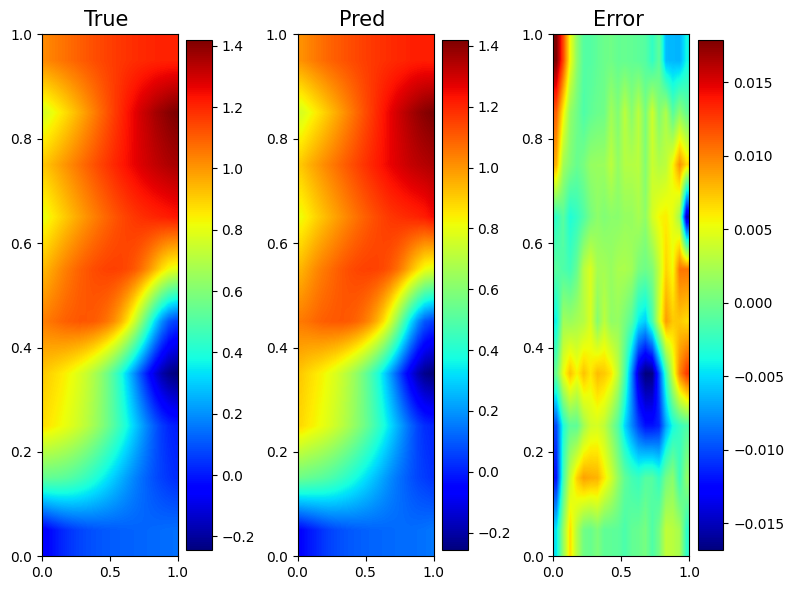

In [5]:
random_n = np.random.randint(0, data.shape[0])
plot_compare_2d(
    true_d=data[random_n, 0],
    pred_d=u_pred[random_n, 0],
)
# plot_compare_2d(data, un(u_pred))

validiation of v

In [6]:
data = (
    torch.tensor(np.load("../../data/reaction_diffusion/reaction_diffusion_v_from_u_v.npy")).float().to("cuda")[9000:]
)
cond = (
    torch.tensor(np.load("../../data/reaction_diffusion/reaction_diffusion_v_from_u_u.npy")).float().to("cuda")[9000:]
)
data = torch.tensor(data).unsqueeze(1)
cond1 = torch.tensor(cond).unsqueeze(1)
cond2 = data[:, :, 0:1].clone().expand(-1, -1, data.shape[2], -1)
cond = torch.concat((cond1, cond2), dim=1)

with torch.no_grad():
    v_pred = renormalize(model2(normalize(cond)))


rmse = relative_error(data, v_pred)
rmse, F.mse_loss(data, v_pred)

C:\Users\taozhan\AppData\Local\Temp\ipykernel_1984\3919096794.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).unsqueeze(1)
C:\Users\taozhan\AppData\Local\Temp\ipykernel_1984\3919096794.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cond1 = torch.tensor(cond).unsqueeze(1)


(0.003906045913696289, tensor(3.0316e-06, device='cuda:0'))

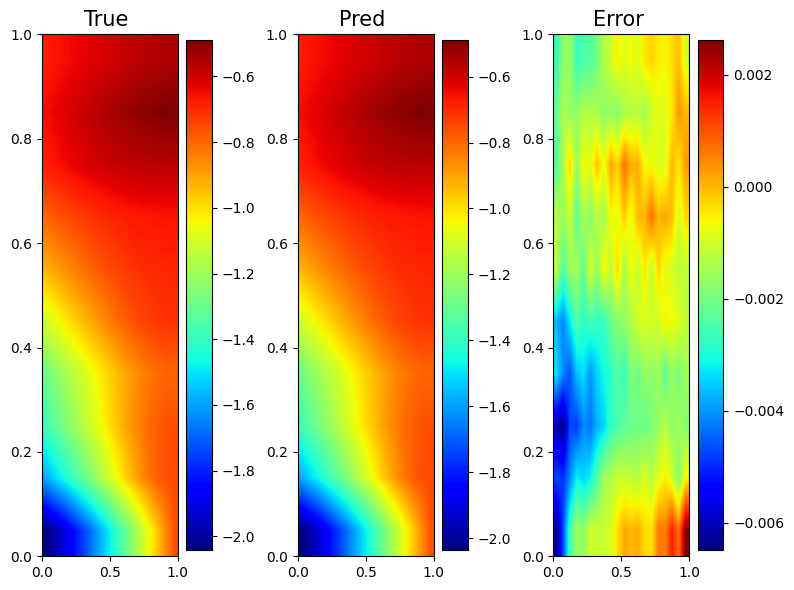

In [7]:
random_n = np.random.randint(0, data.shape[0])
plot_compare_2d(
    true_d=data[random_n, 0],
    pred_d=(v_pred)[random_n, 0],
)
# plot_compare_2d(data, un(u_pred))

compose

In [8]:
data = (
    torch.tensor(np.load(ABSOLUTE_PATH + "/data/reaction_diffusion/reaction_diffusion_uv.npy"))
    .float()
    .to("cuda")[:2000]
)
# data = (data + 5) / 10

data = data.permute(0, 2, 1)

# data1 = np.load('../../data/reaction_diffusion_u_from_v_u.npy')

u, v = data[..., :20].unsqueeze(1), data[..., 20:].unsqueeze(1)

u_intial, v_intial = u[:, :, 0:1].expand(-1, -1, 10, -1), v[:, :, 0:1].expand(-1, -1, 10, -1)

u.shape, u_intial.shape

(torch.Size([2000, 1, 10, 20]), torch.Size([2000, 1, 10, 20]))

In [10]:
import time

u_intial_n, v_intial_n = normalize(u_intial[:1]), normalize(v_intial[:1])

alpha = 0.5

start = time.time()

with torch.no_grad():

    i = 0

    eps = 1

    v_iter = torch.ones_like(v[:1])

    u_iter = torch.ones_like(u[:1])

    while i < 100 and eps > 2e-5:

        i = i + 1

        condv = torch.concat((v_iter, u_intial_n), dim=1)

        u_iter_new = model1(condv)

        condu = torch.concat((u_iter, v_intial_n), dim=1)

        v_iter_new = model2(condu)

        eps = F.l1_loss(u_iter, u_iter_new) + F.l1_loss(v_iter, v_iter_new)

        u_iter = u_iter_new * (1 - alpha) + alpha * u_iter

        v_iter = v_iter_new * (1 - alpha) + alpha * v_iter

        print("iteration: ", i, " eps: ", eps)
end = time.time()
print("time: ", (end - start) / i / 2)

iteration:  1  eps:  tensor(1.9739, device='cuda:0')
iteration:  2  eps:  tensor(1.1781, device='cuda:0')
iteration:  3  eps:  tensor(0.6135, device='cuda:0')
iteration:  4  eps:  tensor(0.3154, device='cuda:0')
iteration:  5  eps:  tensor(0.2972, device='cuda:0')
iteration:  6  eps:  tensor(0.2489, device='cuda:0')
iteration:  7  eps:  tensor(0.1528, device='cuda:0')
iteration:  8  eps:  tensor(0.0933, device='cuda:0')
iteration:  9  eps:  tensor(0.0491, device='cuda:0')
iteration:  10  eps:  tensor(0.0273, device='cuda:0')
iteration:  11  eps:  tensor(0.0204, device='cuda:0')
iteration:  12  eps:  tensor(0.0145, device='cuda:0')
iteration:  13  eps:  tensor(0.0094, device='cuda:0')
iteration:  14  eps:  tensor(0.0062, device='cuda:0')
iteration:  15  eps:  tensor(0.0039, device='cuda:0')
iteration:  16  eps:  tensor(0.0023, device='cuda:0')
iteration:  17  eps:  tensor(0.0012, device='cuda:0')
iteration:  18  eps:  tensor(0.0007, device='cuda:0')
iteration:  19  eps:  tensor(0.0005, 

In [ ]:
mult_p_true = torch.concat((u, v), dim=1)
mult_p_pred = renormalize(torch.concat((u_iter, v_iter), dim=1))


mult_p_true.shape, mult_p_pred.shape

In [ ]:
relative_error(mult_p_pred[:, 0], mult_p_true[:, 0]), relative_error(mult_p_pred[:, 1], mult_p_true[:, 1])

In [ ]:
random_n = np.random.randint(0, data.shape[0])
random_n = -1


plot_compare_2d(
    true_d=mult_p_true[random_n, 1],
    pred_d=mult_p_pred[random_n, 1],
    savep=ABSOLUTE_PATH + "/results/reaction_diffusion/diffusion.pdf",
)